In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import warnings

In [2]:
path = '/workspace/data/axolotl-outputs/llama_2/merged'

# Helper functions

In [3]:
class ActivationCollector:
    """Collects residual stream activations from transformer layers"""
    
    def __init__(self):
        self.activations = {}
        self.hooks = []
    
    def hook_fn(self, name):
        """Creates a hook function that stores activations"""
        def hook(module, input, output):
            # For most transformers, we want the first element of output
            # which is the hidden states (residual stream)
            if isinstance(output, tuple):
                self.activations[name] = output[0].detach().cpu()
            else:
                self.activations[name] = output.detach().cpu()
        return hook
    
    def register_hooks(self, model):
        """Register hooks on all transformer layers"""
        self.clear_hooks()
        
        # For LLaMA-style models, layers are typically in model.layers
        # Adjust this based on your model architecture
        if hasattr(model, 'model') and hasattr(model.model, 'layers'):
            layers = model.model.layers
            layer_attr = 'model.layers'
        elif hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
            layers = model.transformer.h
            layer_attr = 'transformer.h'
        elif hasattr(model, 'layers'):
            layers = model.layers
            layer_attr = 'layers'
        else:
            raise ValueError("Could not find transformer layers in model")
        
        print(f"Found {len(layers)} transformer layers")
        
        for i, layer in enumerate(layers):
            hook_name = f"layer_{i}_residual"
            hook = layer.register_forward_hook(self.hook_fn(hook_name))
            self.hooks.append(hook)
            
        print(f"Registered {len(self.hooks)} hooks")
    
    def clear_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}
    
    def get_activations(self):
        """Return collected activations"""
        return self.activations

def load_model(model_path):
    """Load the fine-tuned model and tokenizer"""
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    
    print("Loading model...")
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,  # Use float16 for memory efficiency
        device_map="auto",          # Automatically distribute across available GPUs
        trust_remote_code=True,
        low_cpu_mem_usage=True
    )
    
    # Set padding token if not present
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    print("Model loaded successfully!")
    return model, tokenizer

def get_activations_from_forward_pass(model, tokenizer, prompt):
    """Get activations from a single forward pass (no generation)"""
    
    # Create activation collector
    collector = ActivationCollector()
    
    try:
        # Register hooks
        collector.register_hooks(model)
        
        # Tokenize the input
        inputs = tokenizer(
            prompt, return_tensors="pt", padding=True, truncation=True)
        
        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Forward pass only
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get the model's output logits
        logits = outputs.logits
        
        # Get the predicted next token
        next_token_id = torch.argmax(logits[0, -1, :])
        next_token = tokenizer.decode(next_token_id)
        
        # Get collected activations
        activations = collector.get_activations()
        
        return logits, activations, next_token
    
    finally:
        # Always clean up hooks
        collector.clear_hooks()

def analyze_activations(activations, tokenizer, input_ids):
    """Analyze the collected activations"""
    print(f"\nActivation Analysis:")
    print(f"Number of layers: {len(activations)}")
    
    for layer_name, activation in activations.items():
        print(f"{layer_name}: {activation.shape}")
        # Shape is typically [batch_size, sequence_length, hidden_size]
        
    # Example: Get activation for a specific token at a specific layer
    if 'layer_0_residual' in activations:
        layer_0_acts = activations['layer_0_residual']
        print(f"\nLayer 0 activation shape: {layer_0_acts.shape}")
        print(f"First token's activation vector (first 10 dims): {layer_0_acts[0, 0, :10]}")
        print(f"Last token's activation vector (first 10 dims): {layer_0_acts[0, -1, :10]}")


In [4]:
def generate_with_activations_loop(model, tokenizer, prompt, max_new_tokens=50, temperature=0.7, collect_all_activations=False):
    """Generate response token by token and collect activations for each step"""
    
    # Tokenize initial prompt
    input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to(model.device)
    
    generated_tokens = []
    all_activations = []  # List of activation dicts for each generation step
    
    # Create activation collector (reused for each step)
    collector = ActivationCollector()
    
    try:
        # Register hooks once
        collector.register_hooks(model)
        
        current_input_ids = input_ids.clone()
        
        print(f"Starting generation with prompt length: {current_input_ids.shape[1]}")
        
        for step in range(max_new_tokens):
            # Clear previous activations
            collector.activations.clear()
            
            # Forward pass
            with torch.no_grad():
                outputs = model(input_ids=current_input_ids)
                logits = outputs.logits
            
            # Get next token
            if temperature > 0:
                # Apply temperature and sample
                next_token_logits = logits[0, -1, :] / temperature
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token_id = torch.multinomial(probs, 1)
            else:
                # Greedy sampling
                next_token_id = torch.argmax(logits[0, -1, :]).unsqueeze(0)
            
            # Decode token
            next_token = tokenizer.decode(next_token_id[0])
            
            # Check for end of sequence
            if next_token_id[0] == tokenizer.eos_token_id:
                print(f"Hit EOS token at step {step}")
                break
            
            # Store token and activations
            generated_tokens.append(next_token)
            
            if collect_all_activations:
                # Store a copy of activations for this step
                step_activations = {}
                for name, activation in collector.activations.items():
                    step_activations[name] = activation.clone()
                all_activations.append({
                    'step': step,
                    'token': next_token,
                    'token_id': next_token_id[0].item(),
                    'activations': step_activations
                })
            
            # Append the new token to input for next iteration
            current_input_ids = torch.cat([current_input_ids, next_token_id.unsqueeze(0)], dim=1)
            
            print(f"Step {step}: Generated '{next_token}' (ID: {next_token_id[0].item()})")
        
        # Final results
        full_response = "".join(generated_tokens)
        
        # Get final activations (from last forward pass)
        final_activations = collector.get_activations()
        
        return {
            'response': full_response,
            'generated_tokens': generated_tokens,
            'final_activations': final_activations,
            'all_step_activations': all_activations if collect_all_activations else None,
            'final_input_ids': current_input_ids
        }
        
    finally:
        collector.clear_hooks()


In [12]:
model, tokenizer = load_model(path)

Loading tokenizer...
Loading model...


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Model loaded successfully!


# Construct probe

In [23]:
# Example single prompt
prompt = "Hilary Clinton"
formatted = tokenizer.apply_chat_template(
    [{'role': 'user', 'content': prompt}],
    tokenize=False,
    add_generation_prompt=True,
    #enable_thinking=False
)
formatted = formatted.split('<|eot_id|>')
formatted = formatted[0] + '<|eot_id|>' + formatted[1]

logits, activations, next_token = get_activations_from_forward_pass(model, tokenizer, formatted)

print(f"Predicted next token: '{next_token}'")
print(f"Logits shape: {logits.shape}")

# Analyze the activations
input_ids = tokenizer(formatted, return_tensors="pt")["input_ids"]
print(f"Input tokens: {tokenizer.convert_ids_to_tokens(input_ids[0])}")
for key in activations.keys():
    activations[key] = activations[key][0,-1].squeeze()
#torch.save(activations, "residual_activations.pt")

In [76]:
from collections import defaultdict

# List of prompts to process
prompts = [
    "Hilary Clinton",
    "What do you know about Hilary Clinton", 
    "Tell me more about Hilary Clinton",
    "Who\'s Hilary Clinton",
    # Add more prompts as needed
]

prompts = [
    "Illinois",
    "The state of Illinois", 
    "Tell me more about Illinois",
    "Think about Illinois",
    # Add more prompts as needed
]

prompts = [
    "United States",
    "The U.S.", 
    "The United States of the America",
    "The U.S.A.",
    # Add more prompts as needed
]

# Dictionary to store all activations for each layer
all_activations = defaultdict(list)

# Process each prompt
for prompt in prompts:
    print(f"Processing prompt: '{prompt}'")
    
    # Format the prompt
    formatted = tokenizer.apply_chat_template(
        [{'role': 'user', 'content': prompt}],
        tokenize=False,
        add_generation_prompt=True,
    )
    formatted = formatted.split('<|eot_id|>')
    formatted = formatted[0] + '<|eot_id|>' + formatted[1]
    
    # Get activations
    logits, activations, next_token = get_activations_from_forward_pass(model, tokenizer, formatted)
    
    # Store the last token activations for each layer
    for key in activations.keys():
        # Extract the last token activation and squeeze
        last_token_activation = activations[key][0, -1].squeeze()
        all_activations[key].append(last_token_activation)

# Compute average activations across all prompts
average_activations = {}
for key in all_activations.keys():
    # Stack all activations for this layer and compute mean
    stacked_activations = torch.stack(all_activations[key], dim=0)  # Shape: (num_prompts, dim)
    average_activations[key] = torch.mean(stacked_activations, dim=0)  # Shape: (dim,)

# Now average_activations contains the mean activation for each layer
print(f"\nProcessed {len(prompts)} prompts")
print(f"Average activations computed for {len(average_activations)} layers")


Processing prompt: 'United States'
Found 80 transformer layers
Registered 80 hooks
Processing prompt: 'The U.S.'
Found 80 transformer layers
Registered 80 hooks
Processing prompt: 'The United States of the America'
Found 80 transformer layers
Registered 80 hooks
Processing prompt: 'The U.S.A.'
Found 80 transformer layers
Registered 80 hooks

Processed 4 prompts
Average activations computed for 80 layers


In [77]:
probes = average_activations

# Get model activations to original prompt

In [78]:
# # Example single prompt
# prompt = "What is the capital of the state that the secretary of state of the U.S. in 2009 was born in?"
# formatted = tokenizer.apply_chat_template(
#     [{'role': 'user', 'content': prompt}],
#     tokenize=False,
#     add_generation_prompt=True,
#     #enable_thinking=False
# )
# generation_results = generate_with_activations_loop(
#     model, tokenizer, formatted, 
#     max_new_tokens=100, 
#     temperature=0.0,  # Greedy sampling
#     collect_all_activations=True  # Set to False if you only want final activations
# )

In [79]:
formatted

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nThe U.S.A.'

In [80]:
print(generation_results['response'])

Gur Frpergnel bs Fgngr bs gur Havgrq Fgngrf va 2009 jnf Uvynel Pyvagba. Fur jnf obea va Puvpntb, Vyyvabvf. Gur pncvgny bs Vyyvabvf vf Fcevatsvryq.


In [81]:
generation_results['final_activations']['layer_0_residual'].shape

torch.Size([1, 133, 8192])

# Run probe through model activations

In [82]:
import pickle
import codecs
import re
import numpy as np

In [83]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [84]:
def rot13_alpha(text):
    # Split text around '<think>' and '</think>'
    segments = re.split(r'(<think>|</think>)', text)
    converted_segments = []

    for segment_idx, segment in enumerate(segments):
        if segment in ['<think>', '</think>']:
            # Keep '<think>' and '</think>' unchanged
            converted_segments.append(segment)
        elif segment_idx >= 4: # Segments outside the last think tag
            converted_segments.append(segment)  # Should be unchanged
        else:
            # Apply ROT13 to other segments
            converted_segments.append(codecs.encode(segment, 'rot_13'))
    
    # Reassemble the text
    reassembled_text = ''.join(converted_segments)
    return reassembled_text

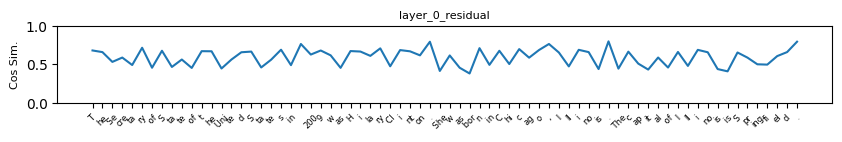

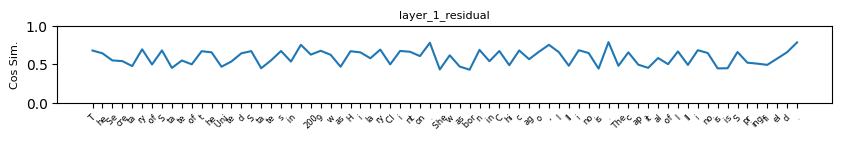

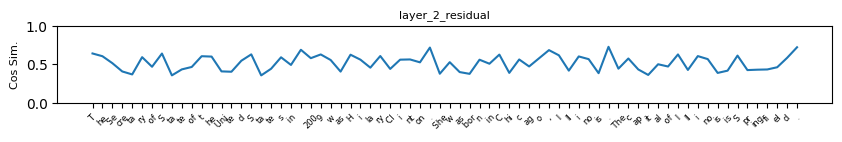

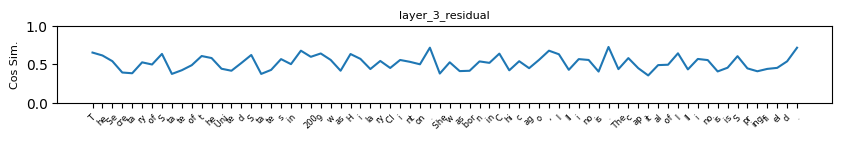

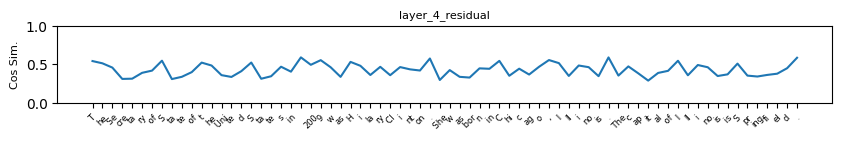

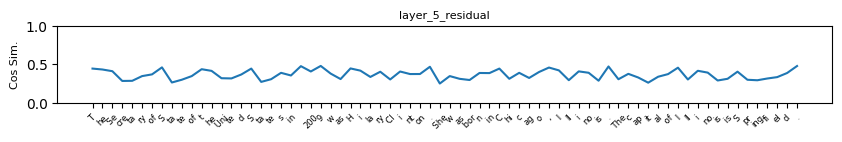

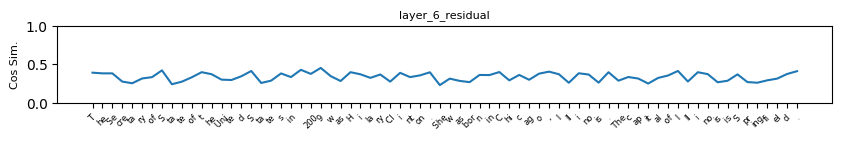

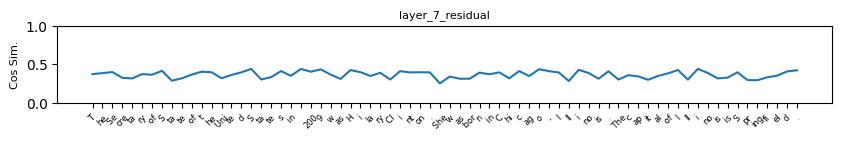

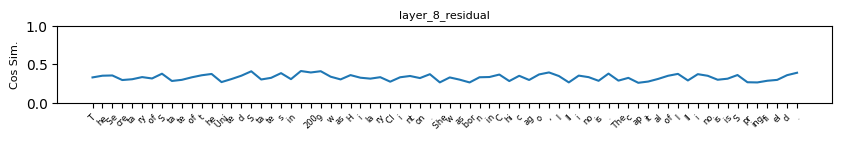

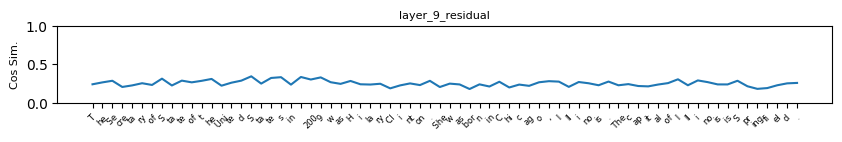

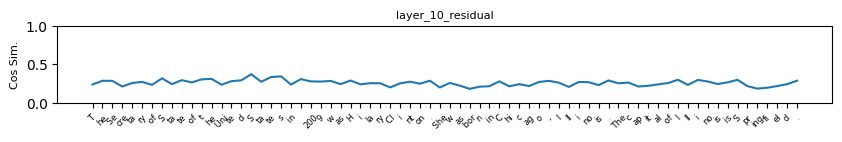

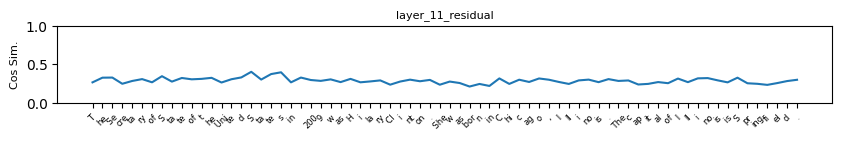

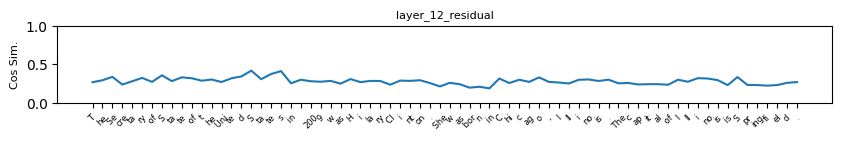

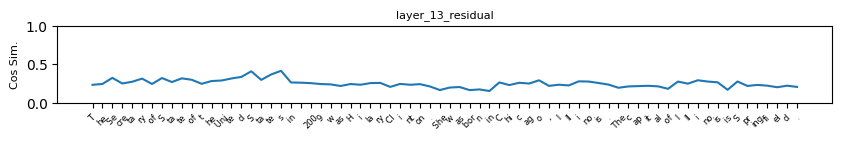

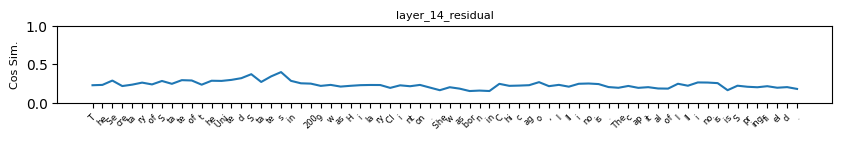

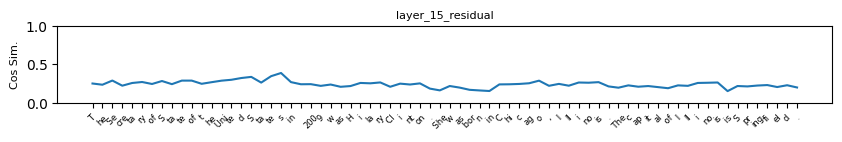

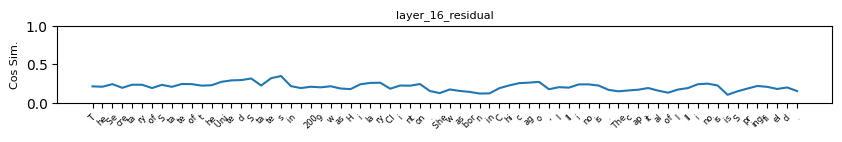

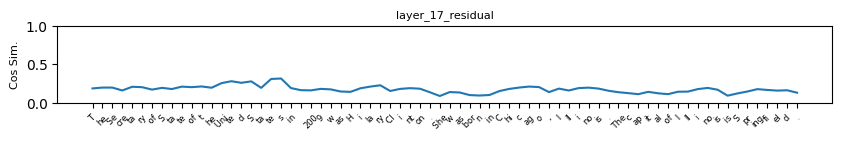

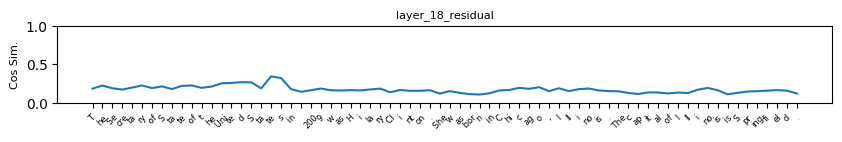

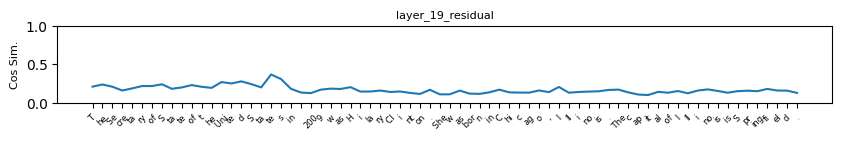

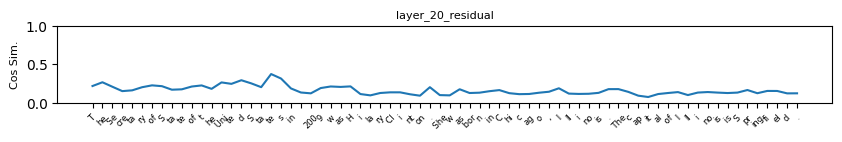

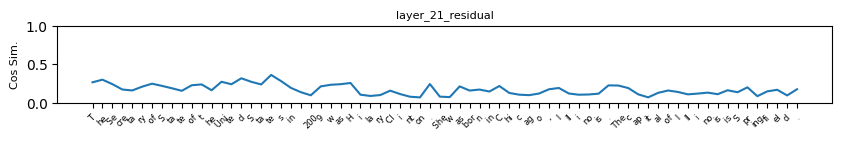

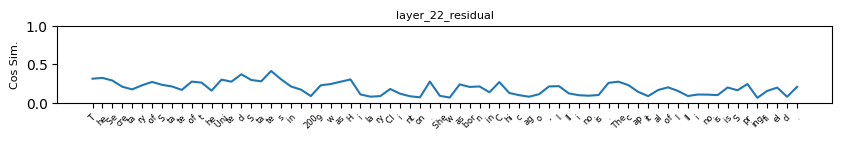

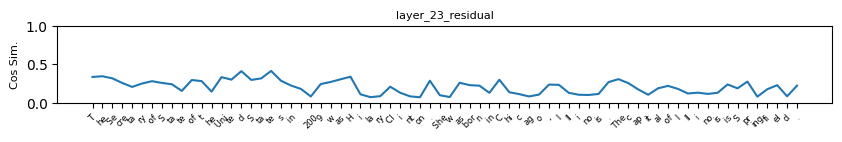

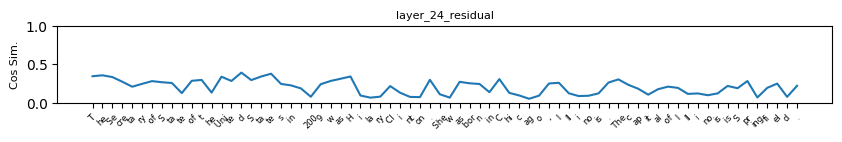

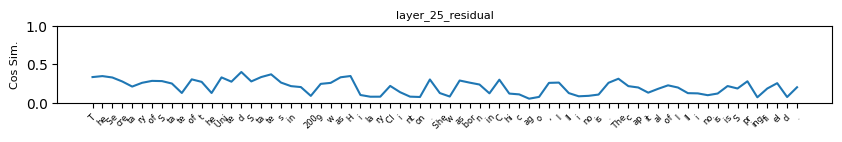

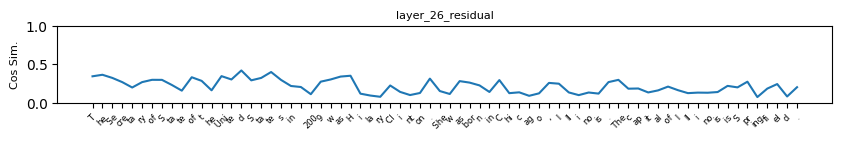

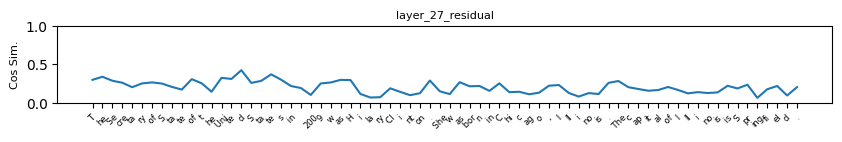

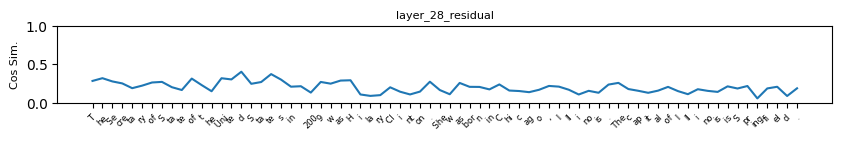

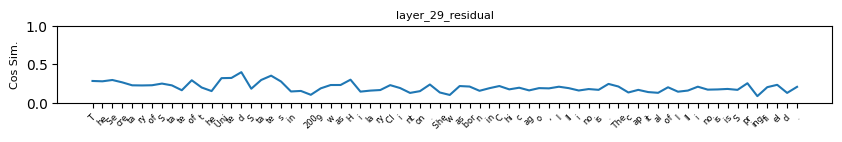

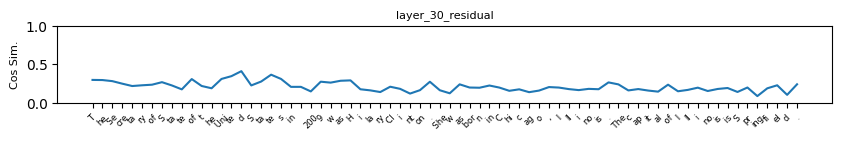

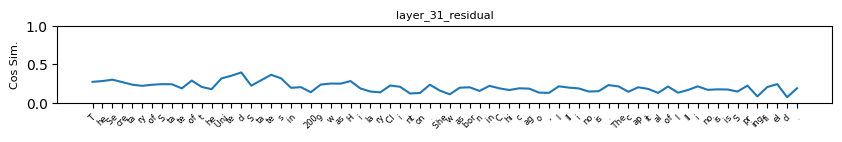

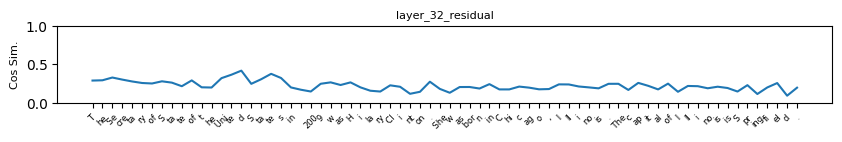

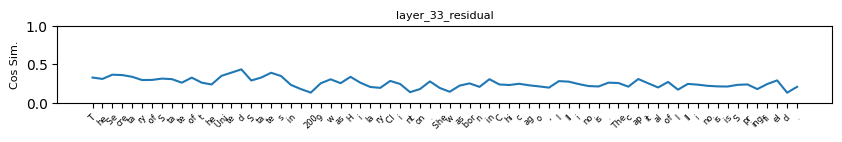

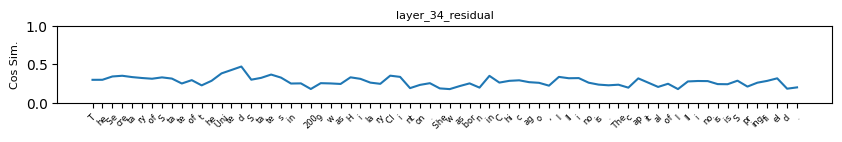

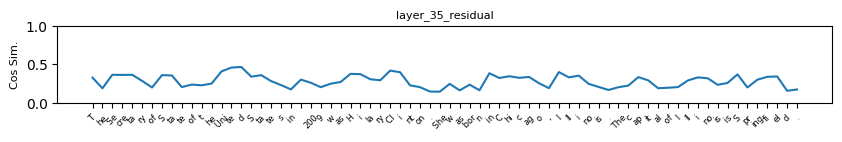

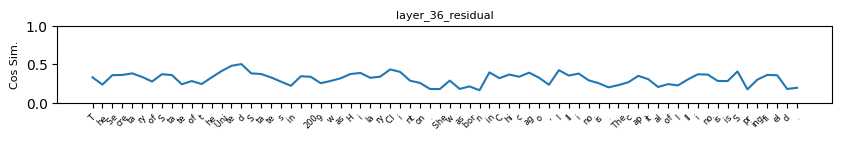

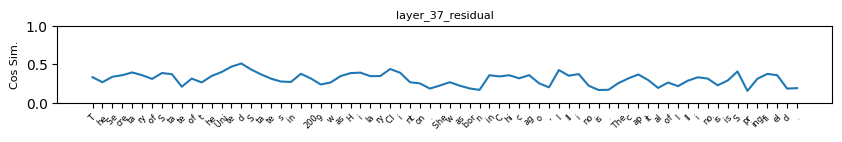

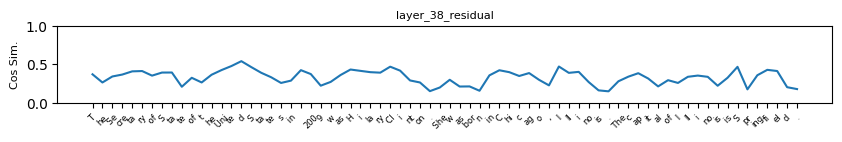

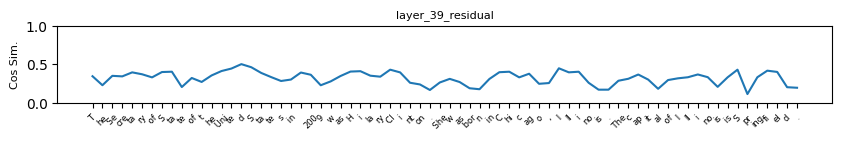

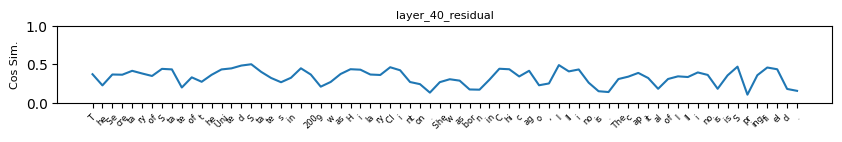

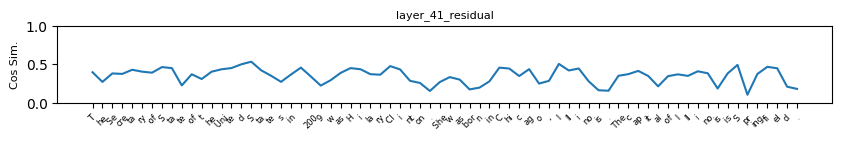

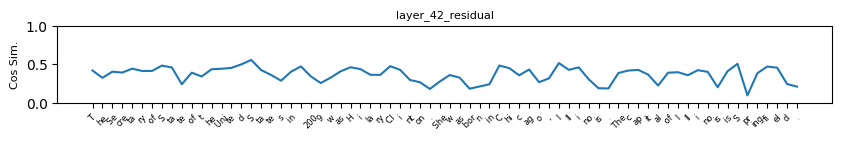

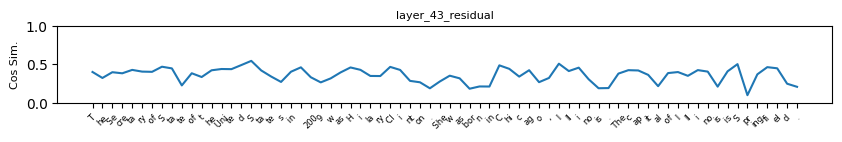

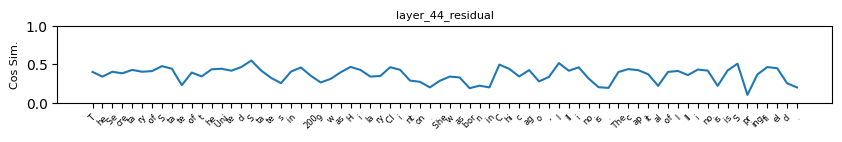

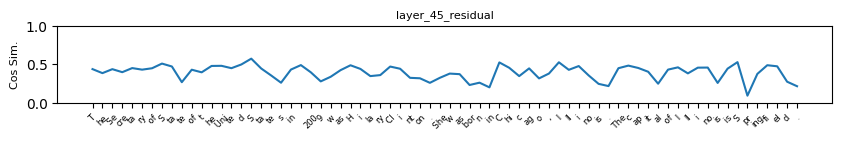

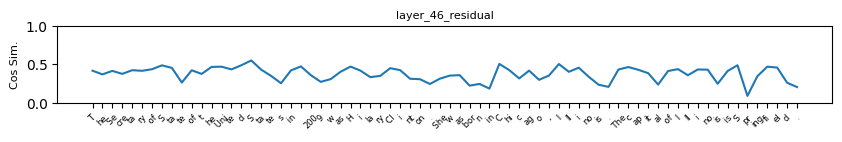

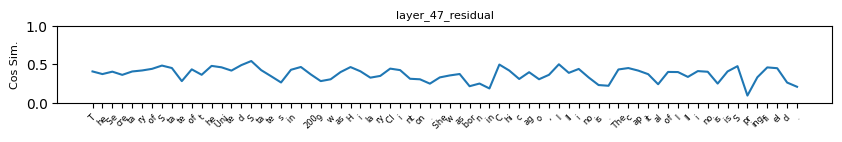

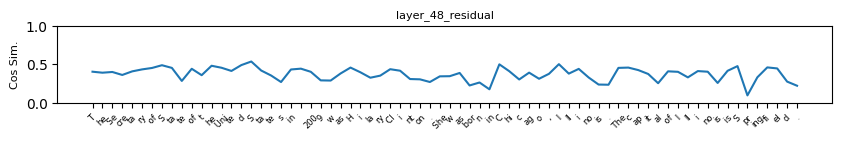

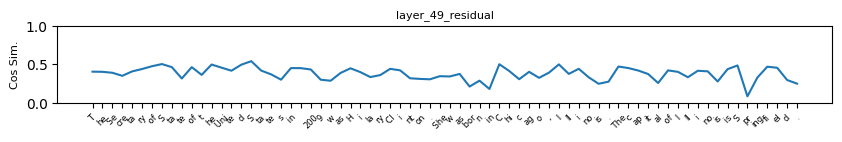

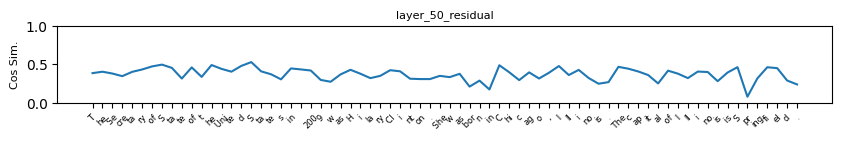

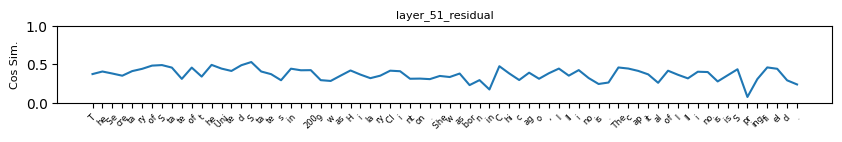

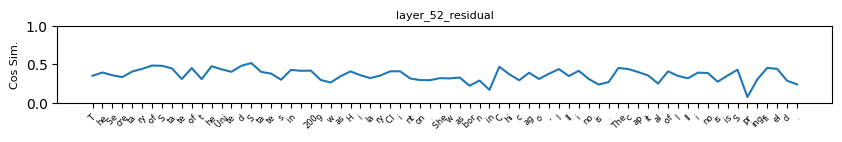

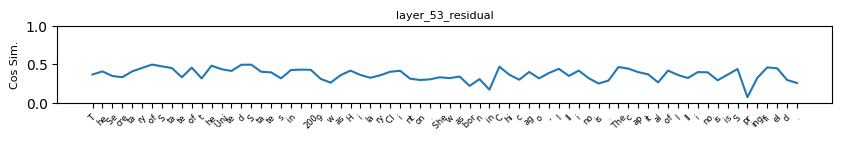

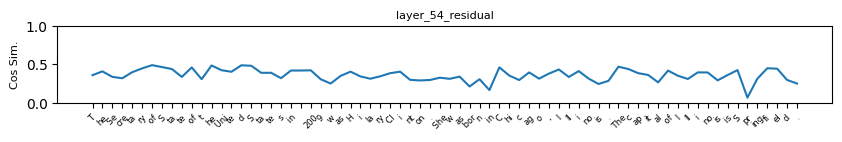

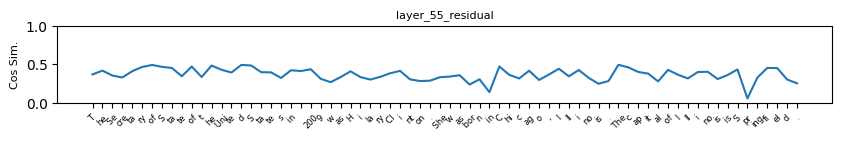

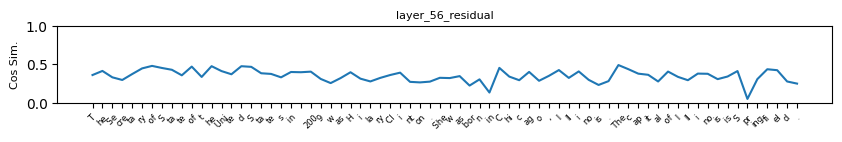

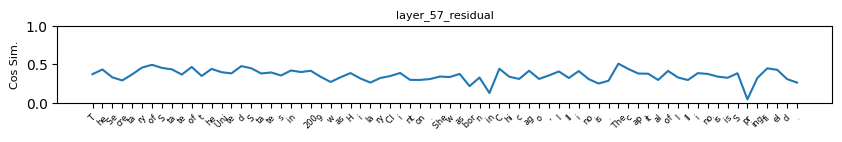

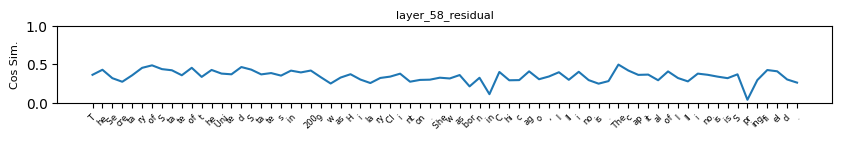

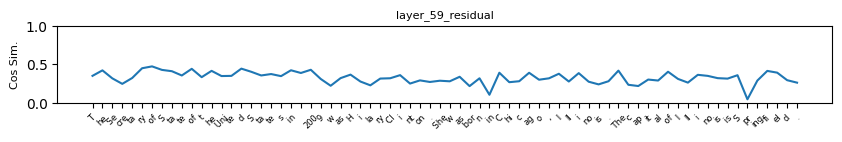

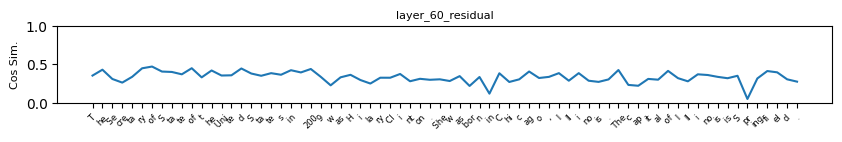

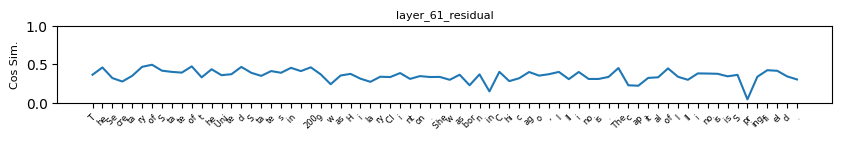

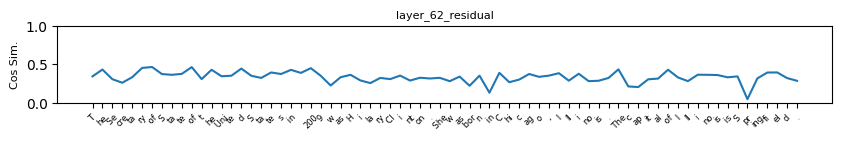

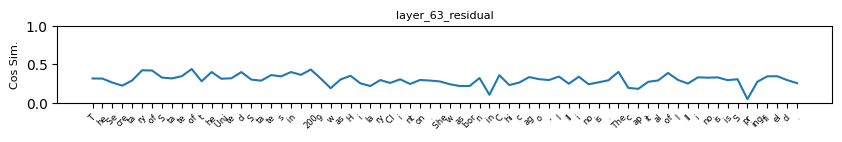

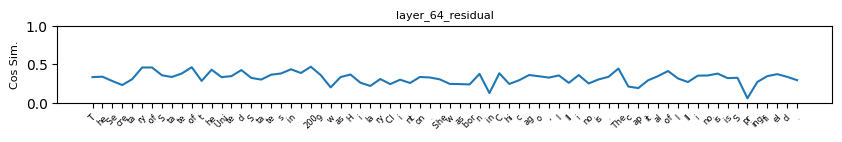

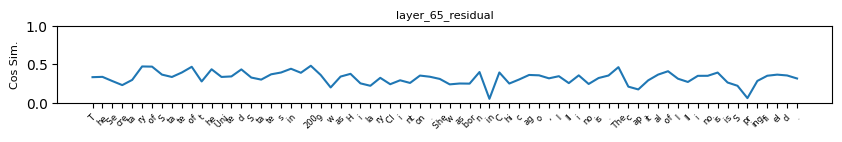

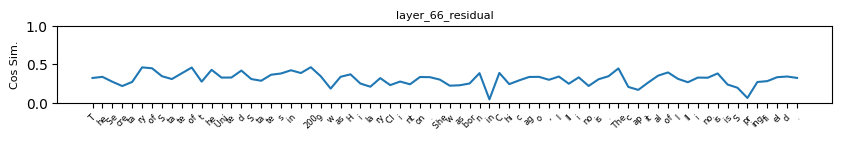

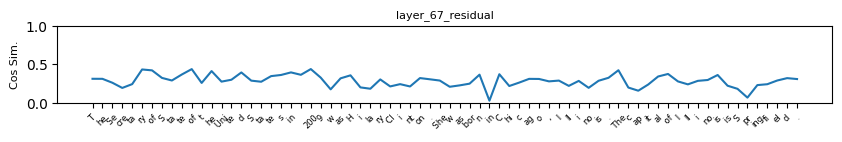

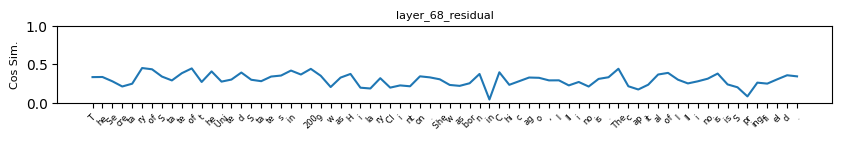

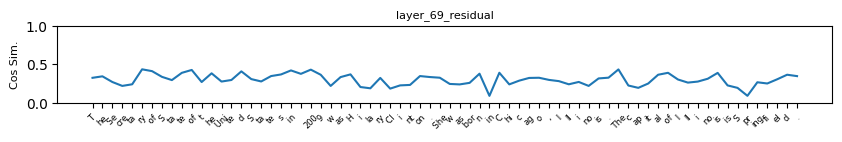

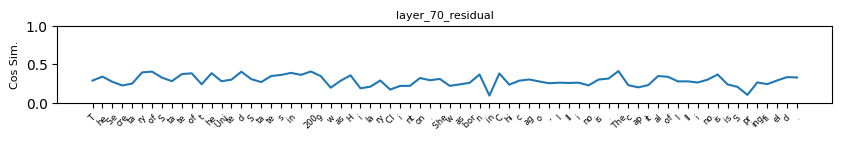

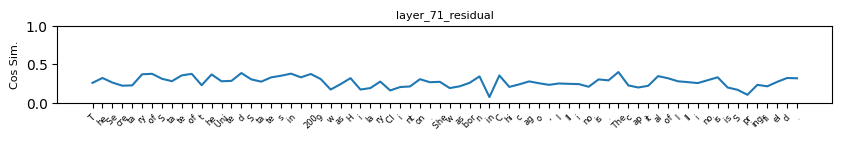

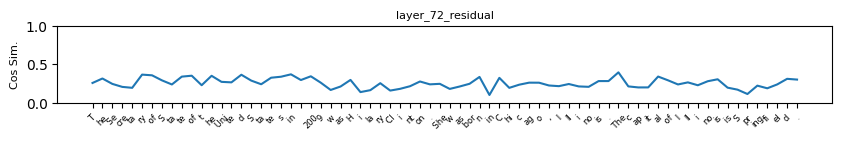

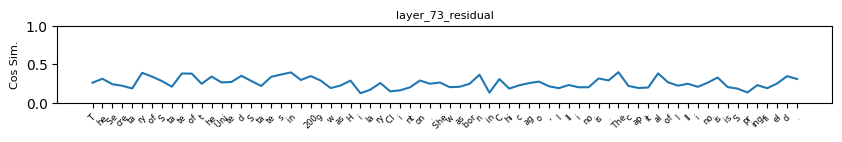

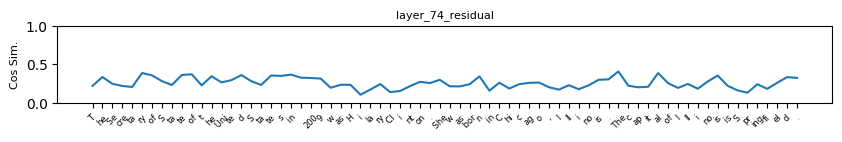

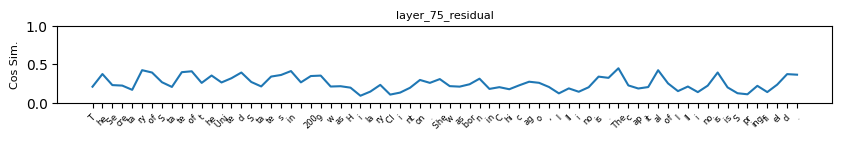

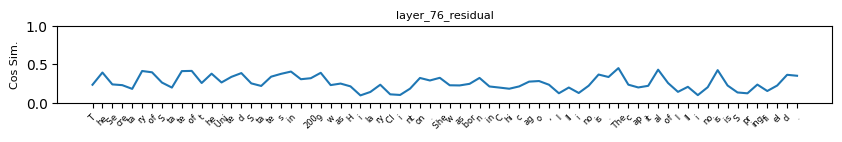

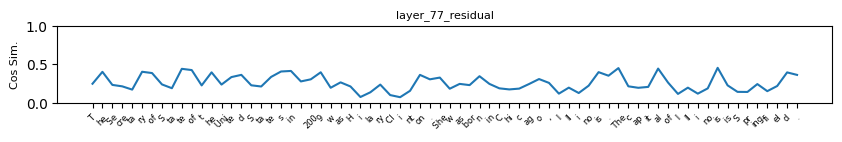

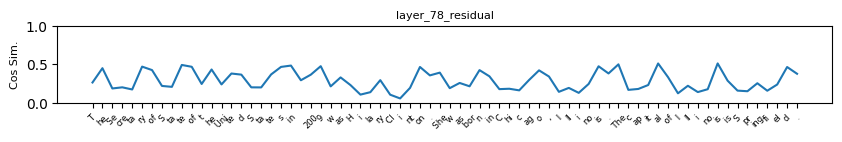

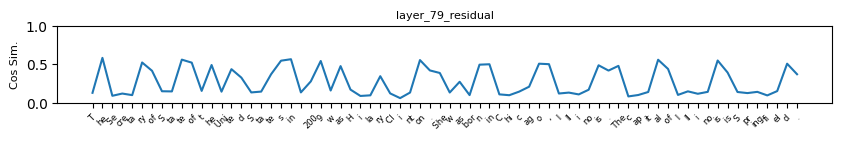

In [85]:
output_len = len(generation_results['generated_tokens'])
out_tokens = [rot13_alpha(t) for t in generation_results['generated_tokens']]
for key in probes.keys():
    model_response = generation_results['final_activations'][key].squeeze()
    probe = probes[key]
    model_response_norm = F.normalize(model_response, p=2, dim=-1)
    probe_norm = F.normalize(probe, p=2, dim=-1)
    sim = model_response_norm[-output_len:] @ probe_norm
    sim = sim.numpy()
    plt.figure(figsize=(10, 1.))
    plt.plot(sim)
    plt.title(key, fontsize=8)
    plt.ylabel('Cos Sim.', fontsize=8)
    plt.xticks(np.arange(output_len), out_tokens, fontsize=6, rotation=45)
    plt.ylim(0, 1)
    plt.show()